In [ ]:
# Xinguo Zhang
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
import h5py
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import Input, Conv1D, Dense, Flatten, Dropout, SimpleRNN, GRU, LSTM, GlobalMaxPooling1D,GlobalMaxPooling2D,MaxPooling2D,BatchNormalization,Concatenate, Softmax, Multiply
from keras.layers import Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import itertools
from keras.utils import plot_model
from keras.layers import Reshape
from keras.layers import Attention
from keras.layers import GlobalAveragePooling1D, MaxPooling1D
from keras.layers import Lambda
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score



In [6]:
class models():
    def __init__(self, path):
        self.path = path
    
    def read_h5(self):
        f = h5py.File(self.path, 'r')
        X = f.get('inputs')
        y = f.get('labels') 
        X = np.array(X)
        y = np.array(y)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=1)
        print(self.x_train.shape)
    
    def build_model(self, input_shape):
        gru_input = Input(shape=input_shape[:-1])  # 调整输入形状

        bigru_layer1 = Bidirectional(GRU(units=128, return_sequences=True))(gru_input)  
        bigru_layer2 = Bidirectional(GRU(units=64, return_sequences=True))(bigru_layer1)  
        gru_model = tf.keras.Model(inputs=gru_input, outputs=bigru_layer2) 

        infcn_input = Input(shape=input_shape)
        inception1 = self.inception_module(infcn_input)
        inception2 = self.inception_module(inception1)

        # 调整形状以适应 GlobalAveragePooling1D
        inception2_reshaped = Reshape((inception2.shape[1], inception2.shape[2] * inception2.shape[3]))(inception2)
        pooling = GlobalAveragePooling1D()(inception2_reshaped)
        infcn_model = tf.keras.Model(inputs=infcn_input, outputs=pooling)

        infcn_output = infcn_model.output
        infcn_flattened = Flatten()(infcn_output)

        # 添加注意力层
        attention_probs = Dense(bigru_layer2.shape[1], activation='softmax', name='attention_vec')(infcn_flattened)
        attention_probs_reshaped = tf.expand_dims(attention_probs, axis=-1)
        attention_probs_reshaped = tf.tile(attention_probs_reshaped, [1, 1, bigru_layer2.shape[-1]])
        attention_mul = Multiply()([bigru_layer2, attention_probs_reshaped])

        # 展平 attention_mul 以便与 infcn_flattened 连接
        attention_mul_flattened = Flatten()(attention_mul)

        concat = Concatenate()([attention_mul_flattened, infcn_flattened])
        output = Dense(6, activation='softmax')(concat)

        model = tf.keras.Model(inputs=[gru_model.input, infcn_model.input], outputs=output)
        self.model = model
    
    def inception_module(self, x):
        conv1 = Conv1D(filters=128, kernel_size=1, activation='relu', padding='same')(x)
        conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
        conv5 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(x)
        conv1_pool = Conv1D(filters=128, kernel_size=1, activation='relu', padding='same')(x)
        concat = Concatenate()([conv1, conv3, conv5, conv1_pool])
        return concat

    def cnn_model(self):
        K = len(set(self.y_train))
        self.x_train = np.expand_dims(self.x_train, -1)
        self.x_test = np.expand_dims(self.x_test, -1)

        input_shape = (self.x_train.shape[1], self.x_train.shape[2], 1)
        self.build_model(input_shape)
        self.model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        self.r = self.model.fit([self.x_train, self.x_train], self.y_train, validation_data=([self.x_test, self.x_test], self.y_test), epochs=150, batch_size=64)
        print(self.model.summary())

        test_loss, test_accuracy = self.model.evaluate([self.x_test, self.x_test], self.y_test)
        print("Test Loss:", test_loss)
        print("Test Accuracy:", test_accuracy)

        # 计算准确率
        self.y_pred = self.model.predict([self.x_test, self.x_test]).argmax(axis=1)
        accuracy = accuracy_score(self.y_test, self.y_pred)
        print("Accuracy:", accuracy)

        # 计算F1分数
        f1score = f1_score(self.y_test, self.y_pred, average='weighted')
        print("F1 Score:", f1score)

        # 计算召回率
        recall = recall_score(self.y_test, self.y_pred, average='weighted')
        print("Recall:", recall)

        # 计算精确率
        precision = precision_score(self.y_test, self.y_pred, average='weighted')
        print("Precision:", precision)
        return self.r
   
    def draw(self):
        f1 = plt.figure(1)
        plt.title('Loss')
        plt.plot(self.r.history['loss'], label = 'loss')
        plt.plot(self.r.history['val_loss'], label = 'val_loss')
        plt.legend()
        f1.show()
        
        f2 = plt.figure(2)
        plt.plot(self.r.history['accuracy'], label = 'accuracy')
        plt.plot(self.r.history['val_accuracy'], label = 'val_accuracy')
        plt.legend()
        f2.show()
        
    # summary, confusion matrix and heatmap
    def con_matrix(self):
        K = len(set(self.y_train))
        self.y_pred = self.model.predict([self.x_test, self.x_test]).argmax(axis=1)
        cm = confusion_matrix(self.y_test, self.y_pred)
        self.plot_confusion_matrix(cm, ['walking', 'walking_upstairs', 'walking_downstairs', 'sitting', 'standing', 'laying'], normalize=True)

    def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.YlGn):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print("Confusion matrix, without normalization")
        print(cm)

        f3 = plt.figure(3, figsize=(12,10))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes, rotation=70)

        fmt = '.2f'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

In [ ]:
#'transient','lying','sitting','standing','walking','running','cycling','Nordic_walking''ascending_stairs','descending_stairs','vacuum_cleaning','ironing'

read h5 file....
(7209, 128, 9)
Epoch 1/150


/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


113/113 [==============================] - 18s 97ms/step - loss: 0.5959 - accuracy: 0.7523 - val_loss: 0.4096 - val_accuracy: 0.8256
Epoch 2/150
113/113 [==============================] - 9s 83ms/step - loss: 0.3387 - accuracy: 0.8606 - val_loss: 0.2576 - val_accuracy: 0.9003
Epoch 3/150
113/113 [==============================] - 9s 83ms/step - loss: 0.1912 - accuracy: 0.9283 - val_loss: 0.1654 - val_accuracy: 0.9437
Epoch 4/150
113/113 [==============================] - 9s 83ms/step - loss: 0.1255 - accuracy: 0.9496 - val_loss: 0.1104 - val_accuracy: 0.9553
Epoch 5/150
113/113 [==============================] - 9s 83ms/step - loss: 0.1145 - accuracy: 0.9530 - val_loss: 0.1060 - val_accuracy: 0.9553
Epoch 6/150
113/113 [==============================] - 10s 84ms/step - loss: 0.1029 - accuracy: 0.9576 - val_loss: 0.0939 - val_accuracy: 0.9608
Epoch 7/150
113/113 [==============================] - 9s 84ms/step - loss: 0.0937 - accuracy: 0.9613 - val_loss: 0.0927 - val_accuracy: 0.9618
Ep

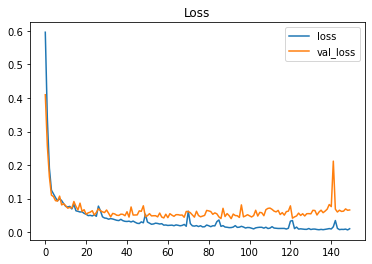

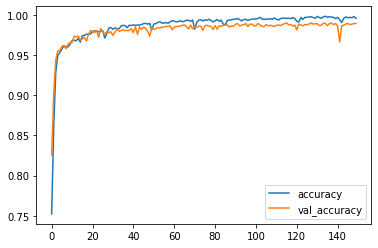

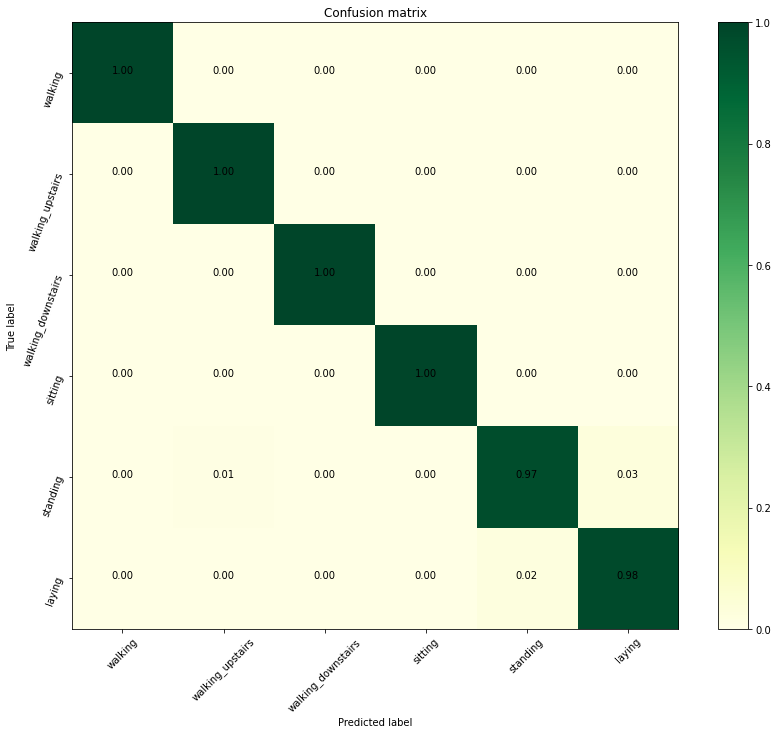

In [24]:
if __name__ == "__main__":
    model_name = "cnn" # can be cnn/dnn/rnn
    path = "./uci_har.h5"
    har = models(path)
    print("read h5 file....")
    har.read_h5()
    if model_name == "cnn":
        har.cnn_model()
        #har.f1_score()
    elif model_name == "dnn":
        har.dnn_model()
    elif model_name == "rnn":
        har.rnn_model()
    har.draw()
    har.con_matrix()